## Base Model Swarm
This is the second in a series of three notebooks for the ODSC presentation 'Harnessing GPT Assistants for Superior Model Ensembles: A Beginner's Guide to AI STacked-Classifiers' ODSC East -- Jason Merwin

In [1]:
import openai
import time
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np
from io import StringIO
import io
import json
import warnings

from config import OPENAI_API_KEY

warnings.filterwarnings('ignore', category=FutureWarning)

# define functions
def delete_all_agents():
    ''' Deletes all exising Assistants '''
    # Fetch the list of assistants
    my_assistants = client.beta.assistants.list(order="desc", limit=20)
    asst_ids = [asst.id for asst in my_assistants.data]
    print(f'Deleting {len(asst_ids)} assistants.')
    # Delete each assistant
    for asst_id in asst_ids:
        client.beta.assistants.delete(asst_id)
        print(f"Deleted assistant with ID: {asst_id}")
    print('Finished deleting all assistants')
    
def delete_all_assistant_files():
    ''' Deletes all exising files uploaded to client using API key '''
    # generate a files object
    files_object = client.files.list()
    # get a list comprehension
    file_ids = [file.id for file in files_object.data]
    print(f'Deleting {len(file_ids)} files.')
    #delete them all
    for file_id in file_ids:
        client.files.delete(file_id)
        print(f"Deleted file with ID: {file_id}")
        time.sleep(1)
    print('Finished deleting all files')   


def upload_csv(file_name):
    response = client.files.create(
        file=open(file_name, "rb"),
        purpose="assistants")
    print(response)
    file_id = response.id
    return file_id

def spin_up(target, base_instructions, file_id):
    # create assistant
    my_assistant = client.beta.assistants.create(
        instructions=base_instructions,
        name="agent",
        tools=[{"type": "code_interpreter"}],
        model="gpt-4-turbo-preview", #"gpt-4-1106-preview", # "gpt-4", # "gpt-3.5-turbo-1106", "gpt-4-turbo-preview"
        file_ids=file_id)
    message_string = "Please execute your ACTIONS on the csv file, the target field is " + target
    # Create a Thread
    thread = client.beta.threads.create()
    # Add a Message to a Thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content= message_string)
    # Run the Assistant
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=my_assistant.id)
    return my_assistant, thread, run 
    print('Finished creating Assistants')
    #assistant, thread, run = spin_up(n, base_instructions, file_id)    
    
def catch_response(assistant, thread, run):
    # Retrieve the run status
    run_status = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id)
    print('########################')
    print('Checking for response...')
    # Handle None response
    if run_status is None:
        print("No response yet")
        return None, None  # Return a tuple of None values to match the expected return type
    # Handle non-completed response
    if run_status.status != 'completed':
        print("Response status is not 'completed'")
        return None, None
    # Handle completed response
    if run_status.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread.id)
        contents = []  # Initialize an empty list to store contents
        # Loop through messages and process content based on role
        for msg in messages.data:
            role = msg.role
            try:
                content = msg.content[0].text.value
                print(f"{role.capitalize()}: {content}")
                contents.append(content)  # Append content to the list
            except AttributeError:
                # This will execute if .text does not exist
                print(f"{role.capitalize()}: [Non-text content, possibly an image or other file type]")
        return messages, contents  # Return messages and a list of contents
    else:
        print('Unable to retrieve message')
        return None, None

def create_dataframes_from_messages(messages, client):
    loop_dfs = []
    # Check if messages is None or messages.data is empty
    if messages is None or not messages.data:
        print("No messages data found.")
        return loop_dfs
    first_thread_message = messages.data[0]  # Accessing the first ThreadMessage
    message_ids = first_thread_message.file_ids
    # Loop through each file ID and create a DataFrame
    for file_id in message_ids:
        # Read the file content
        file_data = client.files.content(file_id)
        # Check if file_data is None
        if file_data is None:
            print(f"No content found for file_id: {file_id}")
            continue  # Skip this iteration and proceed with the next file_id
        file_data_bytes = file_data.read()
        file_like_object = io.BytesIO(file_data_bytes)
        # Create a DataFrame from the file-like object and append
        df = pd.read_csv(file_like_object)
        loop_dfs.append(df)
    return loop_dfs   

def calculate_model_accuracies(df):
    model_accuracy_dict = {}
    # Filter columns that contain probability predictions
    prediction_columns = [col for col in df.columns if "_status" in col]
    
    for col in prediction_columns:
        # Assuming binary classification with 0.5 threshold
        predicted_classes = df[col].apply(lambda x: 1 if x >= 0.5 else 0)
        actual_classes = df[f'{target}']
        # Calculate accuracy
        accuracy = accuracy_score(actual_classes, predicted_classes)
        # Extract model name from column name 
        model_name = col.split("_status")[0]
        model_accuracy_dict[model_name] = accuracy
    
    return model_accuracy_dict

# Initialize API Session

In [2]:
# Instantiate the OpenAI client
client = openai.OpenAI(api_key=OPENAI_API_KEY)

# check training and testing data

In [3]:
#use the feature engineer output
encoded_train = pd.read_csv('meta_train_df.csv')
encoded_val = pd.read_csv('meta_val_df.csv')
target = 'HeartDisease'

display(encoded_train.head())
display(encoded_val.head())

,row_id,Logi_prob,Deci_prob,KNei_prob,Rand_prob,Extr_prob,Supp_prob,Quality
0,0,0.733640,1.0,0.4,0.88,0.86,0.404457,1
1,2,0.514789,0.0,0.6,0.24,0.29,0.933348,0
2,3,0.736664,1.0,0.2,0.87,0.91,0.686683,1
3,5,0.011677,0.0,0.2,0.03,0.06,0.979651,0
4,6,0.954484,1.0,0.6,0.95,0.93,0.963144,1


,row_id,Logi_prob,Deci_prob,KNei_prob,Rand_prob,Extr_prob,Supp_prob,Quality
0,3481,0.497679,0.0,0.8,0.360,0.45,0.263397,0
1,3485,0.056286,0.0,0.4,0.044,0.04,0.022915,0
2,1678,0.449668,0.4,0.0,0.432,0.41,0.108065,0
3,988,0.844107,1.0,0.6,0.956,0.96,0.999231,1
4,1774,0.743276,1.0,0.4,0.802,0.69,0.967124,1


# Create the Swarm

In [4]:
# first make sure any existing bots and files are cleaned up
delete_all_agents()   
delete_all_assistant_files()

Deleting 6 assistants.
Deleted assistant with ID: asst_FgXqaeob9CXQRAYINprkjPQP
Deleted assistant with ID: asst_2Vm76ZWoW52WMlej3vn0Eiew
Deleted assistant with ID: asst_dqwyxzupnXGqdHoNYHvpwhKm
Deleted assistant with ID: asst_xr9jm1HuOAAaBoHYQz90a1jR
Deleted assistant with ID: asst_zRxXfRoAD0g9TSA3HdHbFbTE
Deleted assistant with ID: asst_FfOw3pXneXXDrTW8ksOgrUco
Finished deleting all assistants
Deleting 14 files.
Deleted file with ID: file-NAOn2FuTphnkLovzKEMDT9eH
Deleted file with ID: file-47vFsjfIxMmBl5fxlqYyE1Oe
Deleted file with ID: file-WqBNV7ONbiuFM61FvwMqNsdF
Deleted file with ID: file-WJBa7ZLReLd9P3vv5RtQLtRx
Deleted file with ID: file-Lfe9EAfAgXdnUnpP6K86CHF5
Deleted file with ID: file-hvWVeJASpLjD7aJQ8iW4xoCi
Deleted file with ID: file-JC2YAQxcJEIOoi7ClUgcxMKD
Deleted file with ID: file-ZbqHsUg2EyACTCVJFx87t93m
Deleted file with ID: file-JWFeNSl1tuS04udqLYI0DLpJ
Deleted file with ID: file-qKLhyq9UCf3Gy98kCyehbWN2
Deleted file with ID: file-YGzGkLJzORxDeHTHpOzYEXE8
Deleted fil

In [5]:
# define model types and file names for iteration
model_types = ['Logistic_Regression', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'Random_Forest', 'Extra_Trees_Random_Forest', 'Support Vector Machine']

train_id = upload_csv(f'meta_train_df.csv')
val_id = upload_csv(f'meta_val_df.csv')
file_ids = [train_id, val_id]

agents = []

for i in model_types:
    print(f'Creating {i} assistant')
    
    #assign loop version of models and file names
    model = i
    print('provided these files')
    print(file_ids)
    instructions = instructions = f'''
    You are a data scientist who will build and test a meta model with data output from several base models in the provided csv files.
    When the user asks you to perform your ACTIONS, carry out the described ACTIONS on the provided files.
    The target variable is '{target}'.
    There is an id column to be maintained, unaltered and returned in the output called "row_id". It should be excluded when training the model.

    ACTIONS:

    1.The meta data has been prepared for training and testing a {model} classification model to predict the target variable '{target}'.
    2.Train a {model} classification model using default hyper-parameter values and cross validation on the training data {train_id}. 
    3.Use the trained model to get the '{target}' prediction probabilities from the provided validation data in file {val_id}. It should produce a class probability scores.
    4.Create Table 1 from the validation data class prediction probabilities. The table should have three columns: one for the target values in {val_id} called '{target}', one for the 'row_id' value, and a single column for the predicted status probability called '{model[:4]}_status'.
    5.Prepare Table 1 as a CSV file for the user to download.   
    6.Please do not respond until the table is ready for download.

    DO NOT:
    1. Do not return any images.
    2. Do not return any other tables besides Table 1.
    3. Do not include row_id as a feature in the training of the model.
    4. Do not respond before the validation table is ready for download.
    '''  

    # spin up for each model type and store return object
    assistant, thread, run = spin_up(f'{target}', instructions, file_ids) 
    agents.append((assistant, thread, run, model))  
    print()
    time.sleep(10)

FileObject(id='file-EnndnxwEeiYhrml3whtLqeZ9', bytes=202290, created_at=1713641944, filename='meta_train_df.csv', object='file', purpose='assistants', status='processed', status_details=None)
FileObject(id='file-kz8jiOrS6DTM8uQ222A29j5r', bytes=53835, created_at=1713641944, filename='meta_val_df.csv', object='file', purpose='assistants', status='processed', status_details=None)
Creating Logistic_Regression assistant
provided these files
['file-EnndnxwEeiYhrml3whtLqeZ9', 'file-kz8jiOrS6DTM8uQ222A29j5r']

Creating DecisionTreeClassifier assistant
provided these files
['file-EnndnxwEeiYhrml3whtLqeZ9', 'file-kz8jiOrS6DTM8uQ222A29j5r']

Creating KNeighborsClassifier assistant
provided these files
['file-EnndnxwEeiYhrml3whtLqeZ9', 'file-kz8jiOrS6DTM8uQ222A29j5r']

Creating Random_Forest assistant
provided these files
['file-EnndnxwEeiYhrml3whtLqeZ9', 'file-kz8jiOrS6DTM8uQ222A29j5r']

Creating Extra_Trees_Random_Forest assistant
provided these files
['file-EnndnxwEeiYhrml3whtLqeZ9', 'file-kz8

# Catch the Responses

In [6]:
# run a loop to catch the Agent responses
time.sleep(360) 

agent_responses = []
for assistant, thread, run, model, in agents:
    messages, content = catch_response(assistant, thread, run) 
    agent_responses.append((messages, content, model, assistant))
    time.sleep(10) 

########################
Checking for response...
Assistant: The table with prediction probabilities has been successfully created and saved. You can download it by clicking [here](sandbox:/mnt/data/Prediction_Probabilities_Corrected.csv).
Assistant: I made a mistake in referencing a variable that wasn't correctly defined in the current execution context due to a previous error handling the dataset. I'll correct this oversight by reloading and properly referencing the training and validation datasets with the correct target variable for training and predictions. Let's proceed by fixing these references and properly training the model.
Assistant: It appears that the issue was due to my misunderstanding of the datasets' structure. The target variable in both datasets is named 'Quality' rather than 'HeartDisease'. With this new information, let's train the Logistic Regression model using the correct target variable 'Quality' from the training data and then proceed with predicting and prep

In [7]:
#extract dataframes and compile
df_list = []
for messages, content, model, assistant in agent_responses:
    dataframes = create_dataframes_from_messages(messages, client)
    assistant_id = assistant.id
    df_list.append([dataframes, model, assistant_id])

In [8]:
df_list

[[[     HeartDisease  row_id  Logi_status
   0               0    3481     0.247299
   1               0    3485     0.017446
   2               0    1678     0.363867
   3               1     988     0.982708
   4               1    1774     0.874073
   ..            ...     ...          ...
   795             0    2756     0.014218
   796             0    1433     0.024668
   797             1     492     0.982600
   798             1     462     0.967681
   799             0     737     0.487735
   
   [800 rows x 3 columns]],
  'Logistic_Regression',
  'asst_zfCSzMLxPUrDtH3MfNhjsinG'],
 [[     row_id  HeartDisease  Deci_status
   0      3481             0          0.0
   1      3485             0          0.0
   2      1678             0          1.0
   3       988             1          1.0
   4      1774             1          1.0
   ..      ...           ...          ...
   795    2756             0          0.0
   796    1433             0          0.0
   797     492           

In [9]:
# Initialize an empty dictionary
meta_results_df_dict = {}
failures = []

# Loop through and capture testing data output
for item in df_list:
    try:
        df1 = pd.DataFrame(item[0][0]) 
        if 'row_id' not in df1.columns:
            df1 = df1.reset_index().rename(columns={'index': 'row_id'})
        model = item[1]
        # Extract the first three letters of the model and the fold_id value
        key = model
        # Add the DataFrame to the dictionary with the generated key
        meta_results_df_dict[key] = df1
        
    except:
        assistant_model = item[1]
        failures.append([assistant_model])
        
# Display failed data returns
print('assistants which failed to return a scored training data dataframe:')
print(failures)

assistants which failed to return a scored training data dataframe:
[['KNeighborsClassifier']]


# Prepare Scored Validation Data 

In [10]:
# create a target df to join everything to
list_of_keys = list(meta_results_df_dict.keys())
first_key = list_of_keys[0]
meta_results_data = meta_results_df_dict[first_key]

# Loop through the DataFrames in the dictionary, joining each to the label
for key in meta_results_df_dict:
    if key != first_key and key not in failures:
        # get each dataframe
        cols_to_join = meta_results_df_dict[key]
        # Join with the initial DataFrame on 'row_id'
        meta_results_data = meta_results_data.merge(cols_to_join, on=['row_id', f'{target}'], how='left')
        print(f'joined to {key}')
        
display(meta_results_data)   

joined to DecisionTreeClassifier
joined to Random_Forest
joined to Extra_Trees_Random_Forest
joined to Support Vector Machine


,HeartDisease,row_id,Logi_status,Deci_status,Rand_status,Extr_status,Supp_status
0,0,3481,0.247299,0.0,0.20,0.28,0.123260
1,0,3485,0.017446,0.0,0.00,0.00,0.076169
2,0,1678,0.363867,1.0,0.59,0.55,0.528166
3,1,988,0.982708,1.0,1.00,1.00,0.939259
4,1,1774,0.874073,1.0,0.84,0.93,0.901075
...,...,...,...,...,...,...,...
795,0,2756,0.014218,0.0,0.00,0.00,0.083478
796,0,1433,0.024668,0.0,0.02,0.01,0.054930
797,1,492,0.982600,1.0,1.00,1.00,0.913747
798,1,462,0.967681,1.0,0.99,0.92,0.979083


In [11]:
# save the meta training file
meta_results_data.to_csv('meta_results_data.csv', index=False)
meta_results_data_df = pd.read_csv('meta_results_data.csv')

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score

accuracy_dict = calculate_model_accuracies(meta_results_data_df)

# save both rounds of performance outputs and join in third notebook for a graphic
base_model_accuracy_df = pd.read_csv('base_model_accuracy.csv')

meta_model_accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index').reset_index()
meta_model_accuracy_df.columns = ['Model', 'Accuracy_meta']
result = pd.merge(base_model_accuracy_df, meta_model_accuracy_df, left_on='Model', right_on='Model', how='left')

result

,Model,Accuracy_base,Accuracy_meta
0,Logi,0.78250,0.90125
1,Deci,0.84750,0.86375
2,KNei,0.58875,NaN
3,Rand,0.89375,0.89625
4,Extr,0.90125,0.89875
5,Supp,0.87875,0.89875


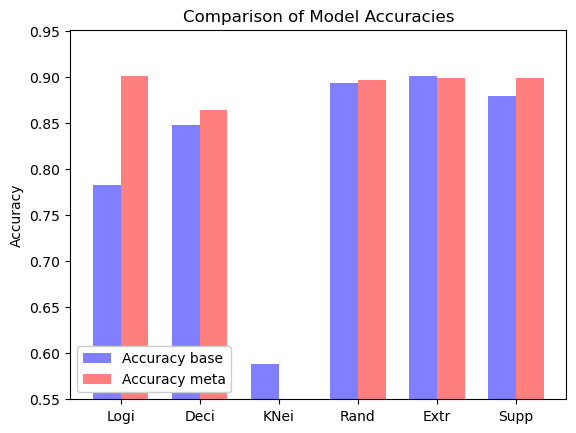

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

df = result.copy()

# Setting the positions and width for the bars
positions = list(range(len(df['Model'])))
width = 0.35

# Plotting accuracy1 and accuracy2 bars for each model type
fig, ax = plt.subplots()
plt.bar([p - width/2 for p in positions], df['Accuracy_base'], width, alpha=0.5, color='b', label='Accuracy base')
plt.bar([p + width/2 for p in positions], df['Accuracy_meta'], width, alpha=0.5, color='r', label='Accuracy meta')

# Adding some labels and a title
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracies')
ax.set_xticks(positions)
ax.set_xticklabels(df['Model'])

# Setting the y-axis to start at 0.5 and adjust upper limit appropriately
ax.set_ylim([0.55, max(df['Accuracy_base'].max(), df['Accuracy_meta'].max()) + 0.05])  # Adjust upper limit if needed

# Adding a legend to show which bars represent what
plt.legend(['Accuracy base', 'Accuracy meta'], loc='lower left', framealpha=1)

# Showing the plot
plt.show()